## from https://web.stanford.edu/~boyd/papers/admm/

# Code

In [1]:
code = grabcode("https://web.stanford.edu/~boyd/papers/admm/group_lasso/group_lasso_feat_split.html")


code =

    'function [x, history] = group_lasso_feat_split(A, b, lambda, ni, RHO, ALPHA)
     % group_lasso_feat_split  Solve group lasso problem via ADMM feature splitting
     %
     % [x, history] = group_lasso_feat_split(A, b, p, lambda, rho, alpha);
     % 
     % solves the following problem via ADMM:
     %
     %   minimize 1/2*|| Ax - b ||_2^2 + \lambda sum(norm(x_i))
     %
     % The input p is a K-element vector giving the block sizes n_i, so that x_i
     % is in R^{n_i}.
     % 
     % The solution is returned in the vector x.
     %
     % history is a structure that contains the objective value, the primal and 
     % dual residual norms, and the tolerances for the primal and dual residual 
     % norms at each iteration.
     % 
     % rho is the augmented Lagrangian parameter. 
     %
     % alpha is the over-relaxation parameter (typical values for alpha are 
     % between 1.0 and 1.8).
     %
     % This version is a (serially) distributed, feature splitting exam

In [2]:
%%file group_lasso_feat_split.m

function [x, history] = group_lasso_feat_split(A, b, lambda, ni, RHO, ALPHA)
% group_lasso_feat_split  Solve group lasso problem via ADMM feature splitting
%
% [x, history] = group_lasso_feat_split(A, b, p, lambda, rho, alpha);
%
% solves the following problem via ADMM:
%
%   minimize 1/2*|| Ax - b ||_2^2 + \lambda sum(norm(x_i))
%
% The input p is a K-element vector giving the block sizes n_i, so that x_i
% is in R^{n_i}.
%
% The solution is returned in the vector x.
%
% history is a structure that contains the objective value, the primal and
% dual residual norms, and the tolerances for the primal and dual residual
% norms at each iteration.
%
% rho is the augmented Lagrangian parameter.
%
% alpha is the over-relaxation parameter (typical values for alpha are
% between 1.0 and 1.8).
%
% This version is a (serially) distributed, feature splitting example.
%
%
% More information can be found in the paper linked at:
% http://www.stanford.edu/~boyd/papers/distr_opt_stat_learning_admm.html
%

t_start = tic;

%% Global constants and defaults

QUIET    = 0;
MAX_ITER = 100;
RELTOL  = 1e-2;
ABSTOL   = 1e-4;

%% Data preprocessing

[m, n] = size(A);

% check that ni divides in to n
if (rem(n,ni) ~= 0)
    error('invalid block size');
end
% number of subsystems
N = n/ni;

%% ADMM solver

rho = RHO;
alpha = ALPHA;    % over-relaxation parameter

x = zeros(ni,N);
z = zeros(m,1);
u = zeros(m,1);
Axbar = zeros(m,1);

zs = zeros(m,N);
Aixi = zeros(m,N);

if ~QUIET
    fprintf('%3s\t%10s\t%10s\t%10s\t%10s\t%10s\n', 'iter', ...
      'r norm', 'eps pri', 's norm', 'eps dual', 'objective');
end

% pre-factor
for i = 1:N,
    Ai = A(:,(i-1)*ni + 1:i*ni);
    [Vi,Di] = eig(Ai'*Ai);
    V{i} = Vi;
    D{i} = diag(Di);

    % in Matlab, transposing costs space and flops
    % so we save a transpose operation everytime
    At{i} = Ai';
end

for k = 1:MAX_ITER
    % x-update (to be done in parallel)
    for i = 1:N,
        Ai = A(:,(i-1)*ni + 1:i*ni);
        xx = x_update(Ai, Aixi(:,i) + z - Axbar - u, lambda/rho, V{i}, D{i});
        x(:,i) = xx;
        Aixi(:,i) = Ai*x(:,i);
    end

    % z-update
    zold = z;
    Axbar = 1/N*A*vec(x);

    Axbar_hat = alpha*Axbar + (1-alpha)*zold;
    z = (b + rho*(Axbar_hat + u))/(N+rho);

    % u-update
    u = u + Axbar_hat - z;

    % compute the dual residual norm square
    s = 0; q = 0;
    zsold = zs;
    zs = z*ones(1,N) + Aixi - Axbar*ones(1,N);
    for i = 1:N,
        % dual residual norm square
        s = s + norm(-rho*At{i}*(zs(:,i) - zsold(:,i)))^2;
        % dual residual epsilon
        q = q + norm(rho*At{i}*u)^2;
    end

    % diagnostics, reporting, termination checks
    history.objval(k)  = objective(A, b, lambda, N, x, z);
    history.r_norm(k)  = sqrt(N)*norm(z - Axbar);
    history.s_norm(k)  = sqrt(s);

    history.eps_pri(k) = sqrt(n)*ABSTOL + RELTOL*max(norm(Aixi,'fro'), norm(-zs, 'fro'));
    history.eps_dual(k)= sqrt(n)*ABSTOL + RELTOL*sqrt(q);


    if ~QUIET
        fprintf('%3d\t%10.4f\t%10.4f\t%10.4f\t%10.4f\t%10.2f\n', k, ...
            history.r_norm(k), history.eps_pri(k), ...
            history.s_norm(k), history.eps_dual(k), history.objval(k));
    end

    if history.r_norm(k) < history.eps_pri(k) && ...
       history.s_norm(k) < history.eps_dual(k);
        break
    end

end

if ~QUIET
    toc(t_start);
end
end

function p = objective(A, b, lambda, N, x, z)
    p = ( 1/2*sum_square(N*z - b) + lambda*sum(norms(x)) );
end

function x = x_update(A, b, kappa, V, D)
[m,n] = size(A);

q = A'*b;

if (norm(q) <= kappa)
   x = zeros(n,1);
else
    % bisection on t
    lower = 0; upper = 1e10;
    for i = 1:100,
        t = (upper + lower)/2;

        x = V*((V'*q)./(D + t));
        if t > kappa/norm(x),
            upper = t;
        else
            lower = t;
        end
        if (upper - lower <= 1e-6)
            break;
        end
    end
end

end

Created file '/home/wenh06/Jupyter/wenhao/workspace/fl_seminar/code/boyd-admm/group_lasso_feat_split.m'.


# Example

In [3]:
eg_code = grabcode("https://web.stanford.edu/~boyd/papers/admm/group_lasso/group_lasso_feat_split_example.html")


eg_code =

    '% Group lasso example with random data
     
     %% Generate problem data
     
     randn('seed', 0);
     rand('seed',0);
     
     m = 200;        % amount of data
     K = 200;        % number of blocks
     ni = 100;       % size of each block
     
     n = ni*K;
     p = 10/K;      % sparsity density  
     
     % generate block sparse solution vector
     x = zeros(ni,K);
     for i = 1:K,
         if( rand() < p)
             % fill nonzeros
             x(:,i) = randn(ni,1);
         end
     end
     x = vec(x);
     
     % generate random data matrix
     A = randn(m,n);
     
     % normalize columns of A
     A = A*spdiags(1./norms(A)',0,n,n);
     
     % generate measurement b with noise
     b = A*x + sqrt(1)*randn(m,1);
     
     % lambda max
     for i = 1:K,
         Ai = A(:,(i-1)*ni + 1:i*ni);
         nrmAitb(i) = norm(Ai'*b);
     end
     lambda_max = max( nrmAitb );
     
     % regularization parameter
     lambda = 0.5*lambda_max;
     

### Generate problem data

In [4]:
randn('seed', 0);
rand('seed',0);

m = 200;        % amount of data
K = 200;        % number of blocks
ni = 100;       % size of each block

n = ni*K;
p = 10/K;      % sparsity density

% generate block sparse solution vector
x = zeros(ni,K);
for i = 1:K,
    if( rand() < p)
        % fill nonzeros
        x(:,i) = randn(ni,1);
    end
end
x = vec(x);

% generate random data matrix
A = randn(m,n);

% normalize columns of A
A = A*spdiags(1./norms(A)',0,n,n);

% generate measurement b with noise
b = A*x + sqrt(1)*randn(m,1);

% lambda max
for i = 1:K,
    Ai = A(:,(i-1)*ni + 1:i*ni);
    nrmAitb(i) = norm(Ai'*b);
end
lambda_max = max( nrmAitb );

% regularization parameter
lambda = 0.5*lambda_max;

xtrue = x;   % save solution

### Solve problem

In [5]:
[x history] = group_lasso_feat_split(A, b, lambda, ni, 10, 1.0);

iter	    r norm	   eps pri	    s norm	  eps dual	 objective
  1	    2.3930	    0.0381	   17.0674	    0.1848	      1.43
  2	    2.2790	    0.0369	    0.8127	    0.3474	      5.46
  3	    2.1705	    0.0358	    0.7740	    0.5022	     11.71
  4	    2.0671	    0.0348	    0.7372	    0.6496	     19.85
  5	    1.9687	    0.0338	    0.7021	    0.7900	     29.58
  6	    1.8750	    0.0329	    0.6686	    0.9237	     40.66
  7	    1.7857	    0.0320	    0.6368	    1.0511	     52.85
  8	    1.7006	    0.0311	    0.6065	    1.1724	     65.93
  9	    1.6197	    0.0303	    0.5776	    1.2879	     79.74
 10	    1.5425	    0.0296	    0.5501	    1.3979	     94.11
 11	    1.4691	    0.0288	    0.5239	    1.5027	    108.90
 12	    1.3991	    0.0281	    0.4989	    1.6025	    123.99
 13	    1.3325	    0.0275	    0.4752	    1.6975	    139.27
 14	    1.2690	    0.0268	    0.4526	    1.7881	    154.65
 15	    1.2035	    0.0262	    0.9770	    1.8739	    171.34
 16	    1.1235	    0.0259	    2.5228	    1.9540	    192

# Reporting

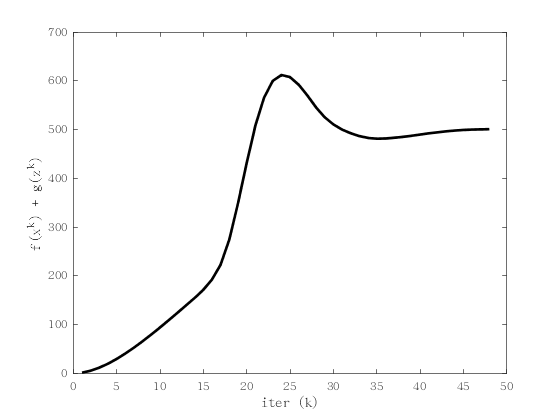

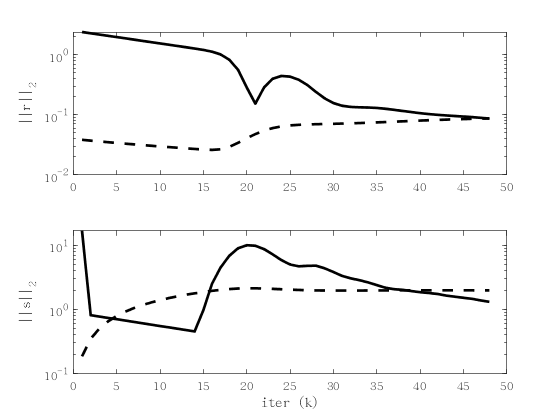

In [7]:
K = length(history.objval);

h = figure;
plot(1:K, history.objval, 'k', 'MarkerSize', 10, 'LineWidth', 2);
ylabel('f(x^k) + g(z^k)'); xlabel('iter (k)');

g = figure;
subplot(2,1,1);
semilogy(1:K, max(1e-8, history.r_norm), 'k', ...
    1:K, history.eps_pri, 'k--',  'LineWidth', 2);
ylabel('||r||_2');

subplot(2,1,2);
semilogy(1:K, max(1e-8, history.s_norm), 'k', ...
    1:K, history.eps_dual, 'k--', 'LineWidth', 2);
ylabel('||s||_2'); xlabel('iter (k)');